In [ ]:
## !pip install mlxtend
## !pip install onnxmltools
## !pip install onnxruntime

In [ ]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
!pip install onnxruntime
!pip install onnxmltools
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 11.4 MB/s eta 0:00:00


In [ ]:
import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType


# **Parameters**

In [ ]:
batch_size    = 16
learning_rate = 0.003
N_Epochs      = 4000
epsilon = 0.0001

# **Read data**

In [ ]:
path_data = '/content/drive/MyDrive/Colab Notebooks/heart.csv'

heart_raw_data = pd.read_csv( path_data, delimiter="," )

In [ ]:
heart_raw_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# **Converting Strings to Integers in Dataset**

In [ ]:
import pandas as pd
import json


heart_raw_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart.csv")


categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


mappings = {}


for col in categorical_cols:
    unique_values = heart_raw_data[col].unique()
    mapping_dict = {val: idx for idx, val in enumerate(unique_values)}


    heart_raw_data[col] = heart_raw_data[col].map(mapping_dict)


    mappings[col] = mapping_dict


print("Converted DataFrame:\n")
print(heart_raw_data.head())


print("\nMappings used for conversion:")
for col, mapping in mappings.items():
    print(f"{col}: {mapping}")

Converted DataFrame:

   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          180          0           0   
2   37    0              0        130          283          0           1   
3   48    1              2        138          214          0           0   
4   54    0              1        150          195          0           0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         0             0  
1    156               0      1.0         1             1  
2     98               0      0.0         0             0  
3    108               1      1.5         1             1  
4    122               0      0.0         0             0  

Mappings used for conversion:
Sex: {'M': 0, 'F': 1}
ChestPainType: {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
RestingECG: {'Normal': 0, 'ST': 1, 'LVH': 2}
Ex

In [ ]:
heart_raw_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,0,140,289,0,0,172,0,0.0,0,0
1,49,1,1,160,180,0,0,156,0,1.0,1,1
2,37,0,0,130,283,0,1,98,0,0.0,0,0
3,48,1,2,138,214,0,0,108,1,1.5,1,1
4,54,0,1,150,195,0,0,122,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,0,132,0,1.2,1,1
914,68,0,2,144,193,1,0,141,0,3.4,1,1
915,57,0,2,130,131,0,0,115,1,1.2,1,1
916,57,1,0,130,236,0,2,174,0,0.0,1,1


In [ ]:
headers_list = heart_raw_data.columns.values.tolist()

headers_list

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

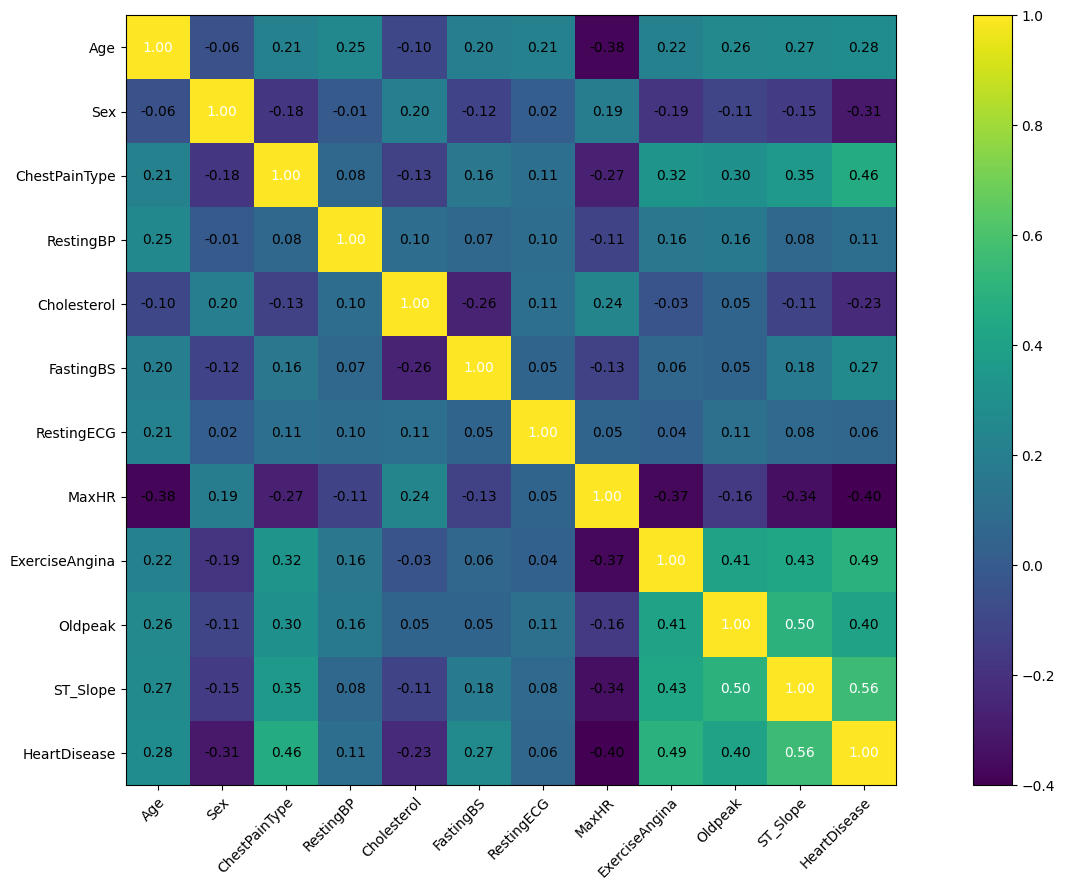

In [ ]:
cm = np.corrcoef(   heart_raw_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show()

In [ ]:
heart_raw_data_np = heart_raw_data.to_numpy()

In [ ]:
heart_raw_data_np

array([[40. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [49. ,  1. ,  1. , ...,  1. ,  1. ,  1. ],
       [37. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [57. ,  0. ,  2. , ...,  1.2,  1. ,  1. ],
       [57. ,  1. ,  0. , ...,  0. ,  1. ,  1. ],
       [38. ,  0. ,  1. , ...,  0. ,  0. ,  0. ]])

In [ ]:
heart_raw_data_np.shape

(918, 12)

In [ ]:
X = heart_raw_data_np[:, :-1]

y = heart_raw_data_np[:, 11:12]

In [ ]:
y

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],

In [ ]:
y = y.astype(int)

In [ ]:
y

array([[0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [ ]:
the_set = np.unique(y)

the_set

array([0, 1])

In [ ]:
len(  the_set  )

2

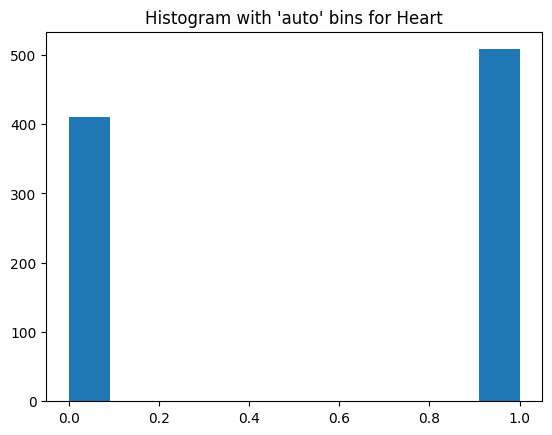

In [ ]:
_ = plt.hist(y, bins='auto')
plt.title("Histogram with 'auto' bins for Heart")
plt.show()

In [ ]:
print(X.shape)

print(y.shape)

(918, 11)
(918, 1)


In [ ]:
random_seed = int(random.random() * 100)
print("Random seed:", random_seed)

Random seed: 72


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(734, 11)
(184, 11)
(734, 1)
(184, 1)


In [ ]:
X_test.dtype

dtype('float64')

In [ ]:
y_test.dtype

dtype('int64')

# **Fix in case float64 error**

In [ ]:
X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.int64 )
y_test  = y_test.astype(   np.int64 )

In [ ]:
X_test.dtype

dtype('float32')

In [ ]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

# **Normalization**

*   Normalizartion
*   Standardization (*)

In [ ]:
x_means      = X_train_tr.mean(0, keepdim=True )

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [ ]:
x_means

tensor([[ 53.5177,   0.2084,   1.4550, 132.2915, 198.5232,   0.2466,   0.5777,
         136.5858,   0.4074,   0.8703,   0.6417]])

In [ ]:
x_means.shape

torch.Size([1, 11])

In [ ]:
x_deviations

tensor([[  9.5548,   0.4066,   0.8584,  18.4917, 109.0861,   0.4314,   0.7932,
          25.3399,   0.4918,   1.0692,   0.6123]])

In [ ]:
x_deviations.shape

torch.Size([1, 11])

# **Creating the DataLoader**

In [ ]:
X_train.shape[0]

734

In [ ]:
heart_train_list = [  ( X_train_tr[i],  y_train_tr[i].item()  )  for i in range( X_train.shape[0] ) ]

heart_test_list  = [  ( X_test_tr[i],   y_test_tr[i].item()   )  for i in range( X_test.shape[0]  ) ]

In [ ]:
heart_train_list[:3]

[(tensor([ 56.,   0.,   0., 126., 166.,   0.,   1., 140.,   0.,   0.,   0.]),
  0),
 (tensor([ 65.0000,   0.0000,   3.0000, 140.0000, 252.0000,   0.0000,   0.0000,
          135.0000,   0.0000,   0.3000,   0.0000]),
  0),
 (tensor([ 46.,   1.,   2., 130., 238.,   0.,   0.,  90.,   0.,   0.,   0.]),
  0)]

In [ ]:
train_dl = torch.utils.data.DataLoader(heart_train_list, batch_size=batch_size, shuffle=True)

In [ ]:
X_test.shape[0]

184

In [ ]:
all_test_data = X_test.shape[0]

test_dl  = torch.utils.data.DataLoader(heart_test_list,  batch_size=all_test_data, shuffle=True)

In [ ]:
train_dl

# **Neural Network Architectures**

In [ ]:
## MLP

class MLP_Net(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(11, 3)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(3, 2)
        self.act2    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)



    def forward(self, x):

        x      = self.linear1(x)
        x      = self.act1(x)

        x      = self.linear2(x)
        y_pred = self.act2(x)

        return y_pred


In [ ]:
## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(11, 15)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(15, 9)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(9, 2)
        self.act3    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        x      = (x - self.x_means) / self.x_deviations

        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)

        return y_pred

# **Training Loop**

In [ ]:
def training_loop( N_Epochs, model, loss_fn, opt  ):

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:



            y_pred = model(xb)

            loss   = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch % 50 == 0:
            print(epoch, "loss=", loss)

# **Core Functions for MLP**

In [ ]:
model      = MLP_Net( x_means, x_deviations  )

opt        = torch.optim.Adam(    model.parameters(), lr=learning_rate )

loss_fn    = nn.CrossEntropyLoss( )

training_loop(  N_Epochs, model, loss_fn, opt  )

0 loss= tensor(0.5691, grad_fn=<NllLossBackward0>)
50 loss= tensor(0.4678, grad_fn=<NllLossBackward0>)
100 loss= tensor(0.3909, grad_fn=<NllLossBackward0>)
150 loss= tensor(0.3225, grad_fn=<NllLossBackward0>)
200 loss= tensor(0.3864, grad_fn=<NllLossBackward0>)
250 loss= tensor(0.3762, grad_fn=<NllLossBackward0>)
300 loss= tensor(0.3844, grad_fn=<NllLossBackward0>)
350 loss= tensor(0.4566, grad_fn=<NllLossBackward0>)
400 loss= tensor(0.4543, grad_fn=<NllLossBackward0>)
450 loss= tensor(0.3851, grad_fn=<NllLossBackward0>)
500 loss= tensor(0.3143, grad_fn=<NllLossBackward0>)
550 loss= tensor(0.5235, grad_fn=<NllLossBackward0>)
600 loss= tensor(0.7415, grad_fn=<NllLossBackward0>)
650 loss= tensor(0.5266, grad_fn=<NllLossBackward0>)
700 loss= tensor(0.3849, grad_fn=<NllLossBackward0>)
750 loss= tensor(0.4566, grad_fn=<NllLossBackward0>)
800 loss= tensor(0.4564, grad_fn=<NllLossBackward0>)
850 loss= tensor(0.3868, grad_fn=<NllLossBackward0>)
900 loss= tensor(0.5275, grad_fn=<NllLossBackward

In [ ]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

In [ ]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        y_pred = model(  x_real  )
        vals, indeces = torch.max( y_pred, dim=1  )
        preds = indeces
        print_metrics_function(y_real, preds)

Accuracy: 0.81
Confusion Matrix:
[[61 27]
 [ 8 88]]
Precision: 0.822
Recall: 0.810
F1-measure: 0.807


# **Core Functions for Deep Learning**

In [ ]:
model      = DL_Net( x_means, x_deviations  )

opt        = torch.optim.Adam(    model.parameters(), lr=learning_rate )

loss_fn    = nn.CrossEntropyLoss( )

training_loop(  N_Epochs, model, loss_fn, opt  )

0 loss= tensor(0.6069, grad_fn=<NllLossBackward0>)
50 loss= tensor(0.4602, grad_fn=<NllLossBackward0>)
100 loss= tensor(0.4852, grad_fn=<NllLossBackward0>)
150 loss= tensor(0.3847, grad_fn=<NllLossBackward0>)
200 loss= tensor(0.3134, grad_fn=<NllLossBackward0>)
250 loss= tensor(0.3133, grad_fn=<NllLossBackward0>)
300 loss= tensor(0.5281, grad_fn=<NllLossBackward0>)
350 loss= tensor(0.3133, grad_fn=<NllLossBackward0>)
400 loss= tensor(0.4566, grad_fn=<NllLossBackward0>)
450 loss= tensor(0.4713, grad_fn=<NllLossBackward0>)
500 loss= tensor(0.4564, grad_fn=<NllLossBackward0>)
550 loss= tensor(0.4561, grad_fn=<NllLossBackward0>)
600 loss= tensor(0.3850, grad_fn=<NllLossBackward0>)
650 loss= tensor(0.3135, grad_fn=<NllLossBackward0>)
700 loss= tensor(0.3133, grad_fn=<NllLossBackward0>)
750 loss= tensor(0.4561, grad_fn=<NllLossBackward0>)
800 loss= tensor(0.3133, grad_fn=<NllLossBackward0>)
850 loss= tensor(0.4563, grad_fn=<NllLossBackward0>)
900 loss= tensor(0.4561, grad_fn=<NllLossBackward

In [ ]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        y_pred = model(  x_real  )
        vals, indeces = torch.max( y_pred, dim=1  )
        preds = indeces
        print_metrics_function(y_real, preds)


Accuracy: 0.81
Confusion Matrix:
[[61 27]
 [ 8 88]]
Precision: 0.822
Recall: 0.810
F1-measure: 0.807


In [ ]:
import torch


model.eval()


dummy_input = torch.randn(1, 11, dtype=torch.float32)


torch.onnx.export(
    model,
    dummy_input,
    "heart_DLNet_model.onnx",
    input_names=["input1"],
    output_names=["output1"],
    opset_version=15,
    do_constant_folding=True,
    dynamic_axes={
        "input1": {0: "batch"},
        "output1": {0: "batch"}
    }
)

print("✅ Heart ONNX model exported!")

✅ Heart ONNX model exported!


/tmp/ipython-input-3623956275.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
